# Problem : Clustering the listings based on latitude, longitude and overall review scores
- We cluster the listings based on latitude, longitude and overall review scores to help the travellers to choose the listings based on the location and also the scores
- Task:Clustering the listings based on latitude, longitude and overall review scores
- Performance measure:Use some metrics provided in sklearn which can measure the performance of K-means learning without ground truth
- Experience:Latitude, longitude and review scores in listings dataset



# Import all the libraries needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import folium
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import sklearn.preprocessing
from sklearn.pipeline import Pipeline
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
sns.color_palette("tab10")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Preprocessing of listings.csv
- Convert price column to numerical
- Remove outliers of price column and plot the boxplot
- Preprocess all the review scores columns to find the overall score which perform K-means better than just passing all the review columns

[Text(0.5, 1.0, 'Box Plot of Price ($)')]

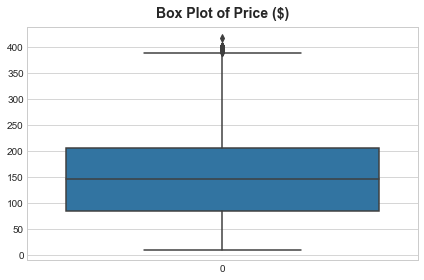

In [2]:
df = pd.read_csv("airbnb Boston/listings.csv")
price_cols_index = df.columns[df.columns.str.contains('price') == True]
for variable in price_cols_index:
    df[variable] = df[variable].map(lambda x: x.replace("$",'').replace(",",''),
                                                na_action = 'ignore')
    df[variable] = df[variable].astype(float)
# Remove outliers
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df["price"] < (Q1 - 1.5 * IQR)) |(df["price"] > (Q3 + 1.5 * IQR)))]
Y = df["price"]
sns.boxplot(data=Y).set(title="Box Plot of Price ($)")

In [3]:
df["review_scores_rating"].fillna(0, inplace=True)
df["review_scores_value"].fillna(0, inplace=True)
df["review_scores_accuracy"].fillna(0, inplace=True)
df["review_scores_cleanliness"].fillna(0, inplace=True)
df["review_scores_checkin"].fillna(0, inplace=True)
df["review_scores_communication"].fillna(0, inplace=True)
df["review_scores_location"].fillna(0, inplace=True)

df["overall_review_scores"] = (df["review_scores_rating"] / 10 + df["review_scores_value"] + df["review_scores_accuracy"] +
                              df["review_scores_cleanliness"] + df["review_scores_checkin"] + df["review_scores_communication"]+
                              df["review_scores_location"]) / 7

# X = df[["latitude", "longitude", "review_scores_rating", "review_scores_value", "review_scores_accuracy",
#         "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location"]]
X = df[["latitude", "longitude", "overall_review_scores"]]

# K-means algorithm
- Use elbow method to decide optimum K
- Use some metrics provided in sklearn which can measure the performance of K-means learning without ground truth to choose the best K
- Plot the relationship between the metrics and the K

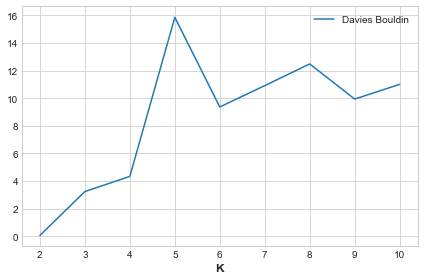

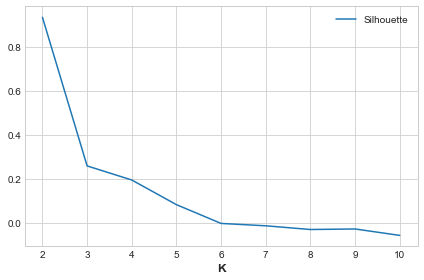

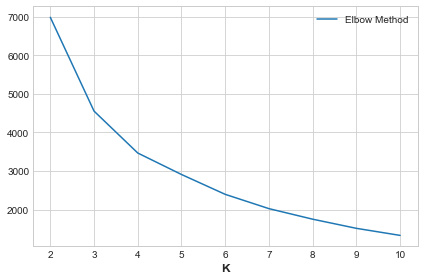

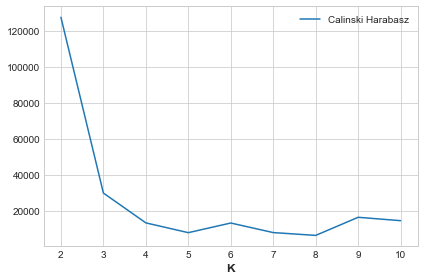

[0.06390059825070264, 3.2395579723548757, 4.338367563816252, 15.862200878461522, 9.367541552958288, 10.912099110005718, 12.484866211388074, 9.94004207102601, 11.00386290342251] [0.9360044047985594, 0.2590944000091523, 0.19489220478685615, 0.08258768020911494, -0.002946237446720261, -0.013737908511405097, -0.03063002464163046, -0.028193592316418114, -0.05744709575727689] [127352.67834994408, 29708.458455446857, 13145.083037814817, 7710.122169759009, 13066.924287786114, 7751.426670857953, 6189.878079786713, 16247.86014052002, 14368.404003473215] [6984.361793999549, 4552.435659373643, 3465.5283423453766, 2909.0411102826197, 2394.1104876411455, 2023.6511263815164, 1750.0740397384047, 1512.9578667116682, 1329.923065371942]


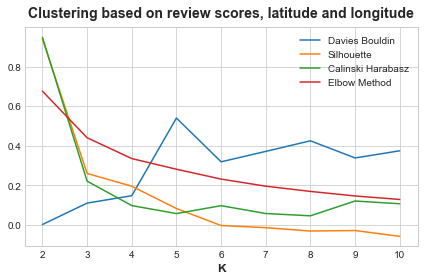

In [4]:
db_score, s_score, ch_score = [], [], []
inertia = []
for n in range(2, 11):
    n_cluster = n
    pipe = Pipeline([
            ("scaling", sklearn.preprocessing.StandardScaler()),
            ("kmeans", KMeans(n_clusters=n))
        ])
    result = pipe.fit(X)
    labels = result["kmeans"].labels_
    db_score.append(davies_bouldin_score(X, labels)) # Low implies well
    s_score.append(silhouette_score(X, labels)) # High implies well
    ch_score.append(calinski_harabasz_score(X, labels)) # High implies well
    inertia.append(result["kmeans"].inertia_) # Low implies well
    
plt.figure()
plt.plot([n for n in range(2, 11)], db_score, label="Davies Bouldin")
plt.xlabel("K")
plt.legend()
plt.show()

plt.figure()
plt.plot([n for n in range(2, 11)], s_score, label="Silhouette")
plt.xlabel("K")
plt.legend()
plt.show()

plt.figure()
plt.plot([n for n in range(2, 11)], inertia, label="Elbow Method")
plt.xlabel("K")
plt.legend()
plt.show()

plt.figure()
plt.plot([n for n in range(2, 11)], ch_score, label="Calinski Harabasz")
plt.xlabel("K")
plt.legend()
plt.show()

print(db_score, s_score, ch_score, inertia)
db_score = sklearn.preprocessing.normalize([db_score])    
s_score = sklearn.preprocessing.normalize([s_score])
ch_score = sklearn.preprocessing.normalize([ch_score])
inertia = sklearn.preprocessing.normalize([inertia])

plt.figure()
plt.title("Clustering based on review scores, latitude and longitude")
plt.plot([n for n in range(2, 11)], db_score[0, :], label="Davies Bouldin")
plt.plot([n for n in range(2, 11)], s_score[0, :], label="Silhouette")
plt.plot([n for n in range(2, 11)], ch_score[0, :], label="Calinski Harabasz")
plt.plot([n for n in range(2, 11)], inertia[0, :], label="Elbow Method")
plt.xlabel("K")
plt.legend()
plt.show()





# Perform the K-Means using the optimal K
- Although from the result above, the optimal K should be 2, but since 2 clusters is too less so we decide to choose the second optimal K, 3

In [5]:
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster).fit(X)
labels = kmeans.labels_
X["cluster"] = labels
X["cluster"] = X["cluster"].astype("category")
X.sample(10)

C:\Users\User\AppData\Local\Temp/ipykernel_8716/720819086.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["cluster"] = labels
C:\Users\User\AppData\Local\Temp/ipykernel_8716/720819086.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["cluster"] = X["cluster"].astype("category")


latitude  longitude  overall_review_scores cluster
79    42.316785 -71.107317               9.614286       2
1963  42.357889 -71.063110              10.000000       2
1748  42.380411 -71.062453               9.285714       2
1492  42.349270 -71.090503               0.000000       1
1806  42.364862 -71.067154               0.000000       1
259   42.302364 -71.114910               9.971429       2
343   42.321732 -71.111870               8.428571       0
1879  42.358431 -71.068146               8.928571       2
247   42.312466 -71.107520               9.857143       2
2535  42.340641 -71.151356               0.000000       1

## Concantenate the clustered data with the price and calculate the mean price, mean score for each cluster

In [6]:
Z = pd.concat([X, Y], axis=1)
mean_price = Z.groupby("cluster")["price"].mean().round(2)
mean_review_score = Z.groupby("cluster")["overall_review_scores"].mean().round(2)

## Visualize number of listings in each cluster

Text(0, 0.5, 'Mean Overall Review Scores')

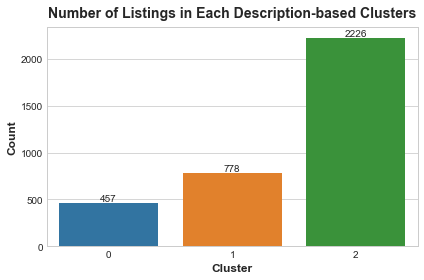

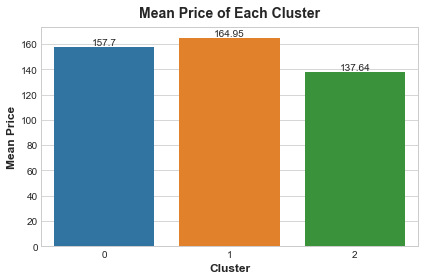

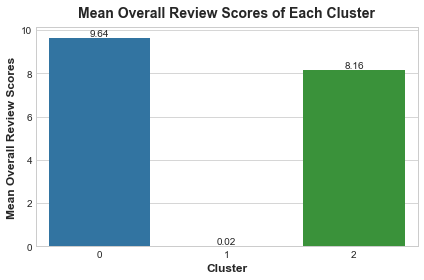

In [7]:
ClusterCount = X['cluster'].value_counts().sort_index()
ClusterCount = pd.DataFrame(ClusterCount)
ClusterCount.columns=['NumListings']
bar = sns.barplot(x=X['cluster'].value_counts().index,y=X['cluster'].value_counts())
bar.bar_label(bar.containers[0])
plt.title('Number of Listings in Each Description-based Clusters')
plt.xlabel("Cluster")
plt.ylabel("Count")

plt.figure()
bar_price = sns.barplot(x=X["cluster"].value_counts().index, y=mean_price)
bar_price.bar_label(bar_price.containers[0])
plt.title("Mean Price of Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Price")

plt.figure()
bar_review_score = sns.barplot(x=X["cluster"].value_counts().index, y=mean_review_score)
bar_review_score.bar_label(bar_review_score.containers[0])
plt.title("Mean Overall Review Scores of Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Overall Review Scores")

## Plot the points and show the mean price of each clustering

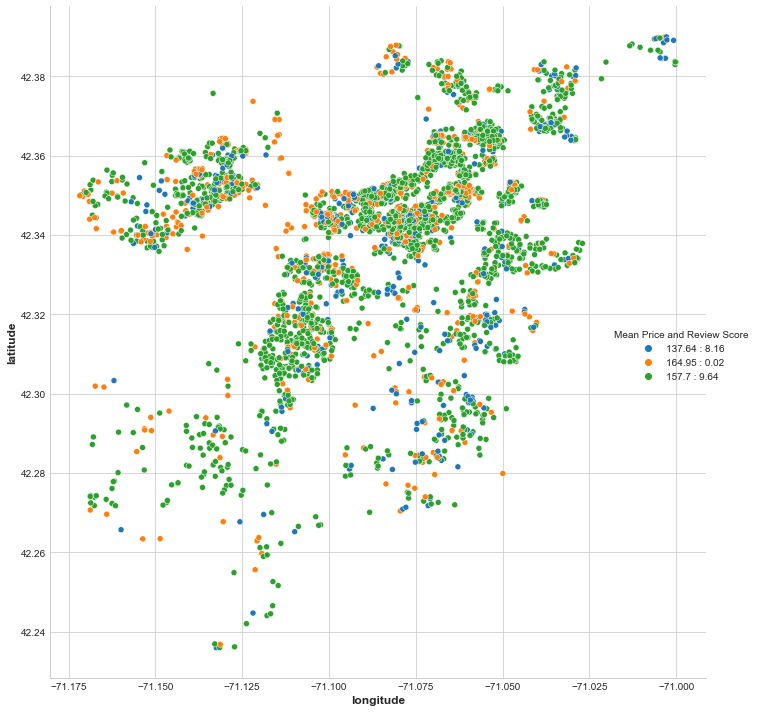

In [8]:
s = sns.relplot(
    x="longitude", y="latitude", hue="cluster", data=X, height=10
)
new_title = 'Mean Price and Review Score'
s._legend.set_title(new_title)
for t, p, s in zip(s._legend.texts, mean_price, mean_review_score):
    t.set_text(f"{p} : {s}")

## Plot the listings on map
- Analyze possible geography factor which affects the price based on the map shown

In [9]:
colors = {0 : 'blue', 1 : 'orange', 2 : "green", 3 : "red", 
          4 : "purple",
          5:"brown", 6:"pink", 7:"grey", 8:"gold", 9:"light blue"
         }
la_mean = X["latitude"].mean()
lo_mean = X["longitude"].mean()

map_osm = folium.Map(location=[la_mean, lo_mean], zoom_start=10, width="%100", height="%100")

X.apply(lambda row:folium.CircleMarker(
    location=[row["latitude"], row["longitude"]], 
    radius=6, fill_color=colors[row["cluster"]],  color=colors[row["cluster"]],
    fill=True, fill_opcaity=1.0, opacity=1,
    popup=folium.Popup(f"Cluster {row['cluster']}<br>Mean Price : {mean_price[row['cluster']]}<br>Mean Score : {mean_review_score[row['cluster']]}", max_width=500)
).add_to(map_osm), axis=1)

map_osm